# Argentina Stock Market - Metrics & Predictions

Install libraries required to get Finance data

In [1]:
!pip install yfinance
!pip install statsmodels
!pip install pmdarima

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=518ee81fdeada73f17af8f47456644dead467c4f1e4306a53c5052c2c7a9c1d4
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance
     |████████████████████████████████| 1.5MB 2.8MB/s 


Import all libraries used in the notebook

In [0]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

This function creates based on list one dataframe that contains all the tickes sorted by Date and Ticker

The period defined to analyze is 5 years

In [0]:
def create_df_portfolio(portfolio, allocation=None, periodic_metric='1y', money_to_invest=0):
  
  df = None
  idx = 0
  
  for ticker in portfolio:
    df_ticker = yf.download(ticker, period=periodic_metric)
    df_ticker['Ticker'] = ticker
    df_ticker = df_ticker.reset_index()
    df_ticker = df_ticker.set_index(['Date'])

    df_ticker['Adj_Close'] = df_ticker['Adj Close']

    #Normalized returns are taken to mean returns that are coherent but that are not based on any macroeconomic forecasts.
    #Based on the first adjusted close calculate the normalized returns each day 
    df_ticker['Normalized_Return'] = df_ticker['Adj_Close'] / df_ticker.iloc[0]['Adj_Close']
    
    if allocation == None:
      df_ticker['Allocation'] = 0
    else:
      #distribution defined by the investor
      df_ticker['Allocation'] = df_ticker['Normalized_Return'] * (allocation[idx] / 100)

    #calculates based on the money to invest the performance for each ticker 
    df_ticker['Position_Values'] = df_ticker['Allocation'] * money_to_invest

    del df_ticker['Open']
    del df_ticker['High']
    del df_ticker['Low']
    del df_ticker['Close']
    del df_ticker['Volume']
    del df_ticker['Adj Close']

    if isinstance(df, pd.DataFrame) == False:
      df = df_ticker      
    else:      
      df = pd.concat([df_ticker,df])
      df.sort_index()

    idx = idx + 1

  return df

In [0]:
def plot_all_in_one(df, value, year=None):
  if year != None:
    df = df[df.index.year==year]
  
  df = df.drop(index=df.index.max())
  df = df.reset_index() 
  plot = df.pivot(index='Date', columns='Ticker', values=value).plot(grid=True, figsize=(10,8))

  if year != None:
    plot.set_title("Year: " + str(year))
  else:
    plot.set_title("History")

**Defines the portfolio**

In [5]:
portfolio_banking = ['GGAL.BA', 'BMA.BA', 'SUPV.BA']

#defines an estimated allocation for each ticker
portfolio_allocation_percent = [30, 40, 30]

#create dataframe
df_portfolio_banking = create_df_portfolio(portfolio_banking, portfolio_allocation_percent, '1y',  10000)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


**Total Position calculated**

It is essentially the worth of all positions if they were to be liquidated at a particular point in time. 

In the first element, we can check that the value is the same as the money invested.

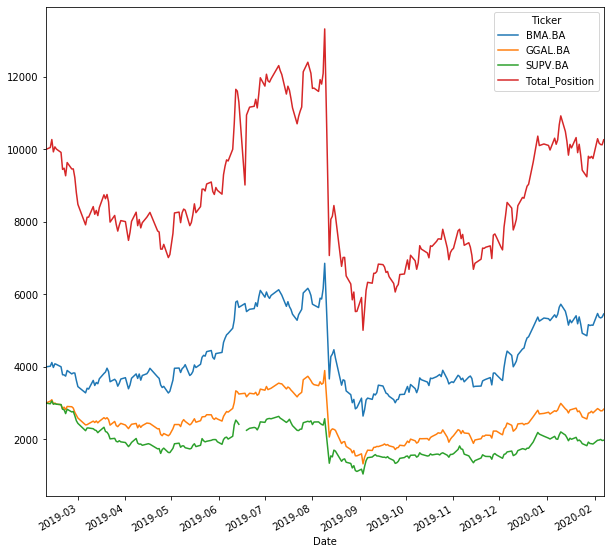

In [6]:
df_portfolio_position = df_portfolio_banking.reset_index() 
df_portfolio_position = df_portfolio_position.pivot(index='Date', columns='Ticker', values='Position_Values')
df_portfolio_position['Total_Position'] = df_portfolio_position.sum(axis=1)
df_portfolio_banking['Total_Position'] = df_portfolio_position['Total_Position']
df_portfolio_position.plot(figsize=(10,10))

**Optimizing the Portfolio**

**Markowitz Portfolio Optimization**

Is a theory on how risk-averse investors can construct portfolios to optimize or maximize expected return based on a given level of market risk, emphasizing that risk is an inherent part of higher reward. According to the theory, it's possible to construct an "efficient frontier" of optimal portfolios offering the maximum possible expected return for a given level of risk.

It makes the assumption that investors are risk-averse, meaning they prefer a less risky portfolio to a riskier one for a given level of return. This implies that an investor will take on more risk only if is expecting more reward.

In [0]:
def markowitz_portfolio_optimization(df, portfolio, number_of_possible_portfolio, trade_business_days = 252):

  all_weights = np.zeros((number_of_possible_portfolio, len(portfolio)))

  array_returns = np.zeros(number_of_possible_portfolio)
  array_volatility = np.zeros(number_of_possible_portfolio)
  array_sharpe = np.zeros(number_of_possible_portfolio)

  log_ret = np.log(df/df.shift(1))

  for index in range(number_of_possible_portfolio):

    #looking for the best weight in all portfolio based on relation Returns vs Volatility
    weights = np.array(np.random.random(len(portfolio)))
    weights = weights / np.sum(weights)

    all_weights[index,:] = weights
    array_returns[index] = np.sum(log_ret.mean()*weights*trade_business_days)
    array_volatility[index] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * trade_business_days, weights)))

    array_sharpe[index] = array_returns[index] / array_volatility[index]

  
  return [all_weights, array_returns, array_volatility, array_sharpe]


In [0]:
def simulate_portfolio(df, portfolio_banking, number_of_possible_portfolio):
  #call optimization function
  weights, returns, volatility, sharpe = markowitz_portfolio_optimization(df, portfolio_banking, number_of_possible_portfolio)

  #get best weights in the optimization process
  best_sharpe_weights = weights[sharpe.argmax(),:]

  plt.figure(figsize=(10,10))
  plt.scatter(volatility, returns, c=sharpe, cmap = 'viridis')
  plt.colorbar(label='Sharpe Ratio')
  plt.xlabel('Volatility')
  plt.ylabel('Return')
  plt.scatter(volatility[sharpe.argmax()], returns[sharpe.argmax()], c ='red', edgecolors='white', s=100)

Red point is the best relation between Returns vs Volatility

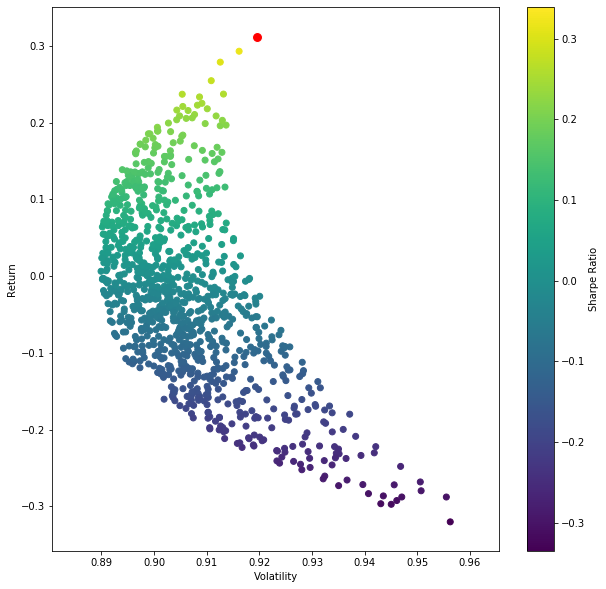

In [9]:
df = df_portfolio_banking
df = df.reset_index() 
df = df.pivot(index='Date', columns='Ticker', values='Adj_Close')

simulate_portfolio(df, portfolio_banking, 1000)

**Compare Sharpe Ratio using different portfolios based on the metric**

The Sharpe ratio measures the performance of an investment compared to a risk-free asset, after adjusting for its risk. It is defined as the difference between the returns of the investment and the risk-free return, divided by the standard deviation of the investment.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


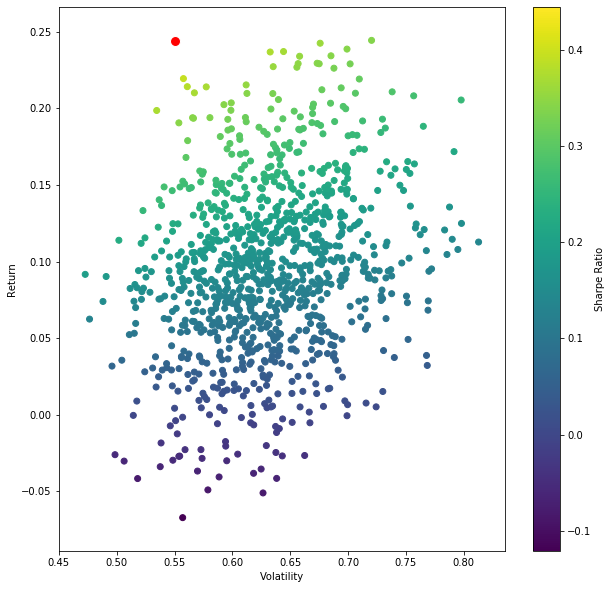

In [10]:
all_portfolio_banking = ['BHIP.BA', 'BMA.BA', 'BPAT.BA', 'BRIO.BA', 'GGAL.BA']
df_portfolio = create_df_portfolio(all_portfolio_banking)
df_portfolio = df_portfolio.reset_index() 
df_portfolio = df_portfolio.pivot(index='Date', columns='Ticker', values='Adj_Close')

simulate_portfolio(df_portfolio, all_portfolio_banking, 1000)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


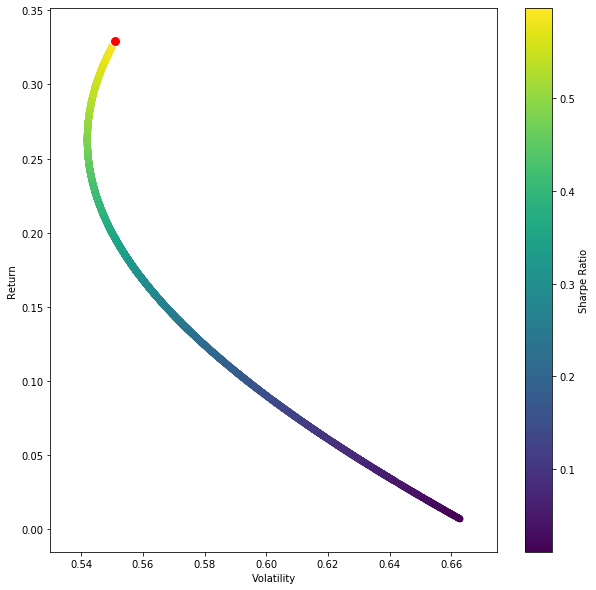

In [11]:
all_portfolio_banking = ['BRIO.BA', 'BPAT.BA']
df_portfolio = create_df_portfolio(all_portfolio_banking)
df_portfolio = df_portfolio.reset_index() 
df_portfolio = df_portfolio.pivot(index='Date', columns='Ticker', values='Adj_Close')

simulate_portfolio(df_portfolio, all_portfolio_banking, 5000)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


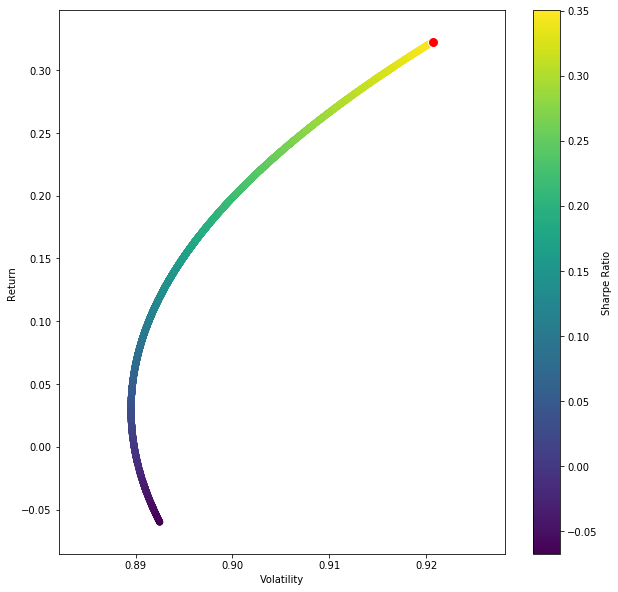

In [12]:
all_portfolio_banking = ['GGAL.BA', 'BMA.BA']
df_portfolio = create_df_portfolio(all_portfolio_banking)
df_portfolio = df_portfolio.reset_index() 
df_portfolio = df_portfolio.pivot(index='Date', columns='Ticker', values='Adj_Close')

simulate_portfolio(df_portfolio, all_portfolio_banking, 5000)

**Predicting Ticker Price using History**

The history of the ticker price can get us a view what is the expected behaviour in the next days. This is just an approach because also the stock prices can be impacted by the government decision, natural disasters and so on.

In [0]:
def predict_price_by_history(df, ticker):

  result = seasonal_decompose(df, model='multiplicative', freq = 30)
  figure_season = plt.figure()  
  figure_season = result.plot()  
  figure_season.set_size_inches(10, 8)
  
  #eliminate trend component in serie
  df_log = np.log(df)
  train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

  plt.figure(figsize=(10,8))
  plt.grid(True)
  plt.xlabel('Date')
  plt.ylabel('Close Prices')
  plt.plot(df_log, 'blue', label='Train data')
  plt.plot(test_data, 'red', label='Test data')
  plt.legend()

  model = ARIMA(train_data, order=(3, 1, 2))  
  fitted = model.fit(disp=-1)  

  # Forecasting values with 95% conf
  fc, se, conf = fitted.forecast(25, alpha=0.05)

  fc_series = pd.Series(fc, index=test_data.index)
  lower_series = pd.Series(conf[:, 0], index=test_data.index)
  upper_series = pd.Series(conf[:, 1], index=test_data.index)

  plt.figure(figsize=(10,8))
  plt.plot(train_data, color = 'blue', label='Training')
  plt.plot(test_data, color = 'red', label='Actual Price')
  plt.plot(fc_series, color = 'orange',label='Predicted')
  plt.fill_between(lower_series.index, lower_series, upper_series, 
                  color='k', alpha=.10)
  plt.title(ticker + ' Price Prediction')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend(loc='upper left', fontsize=8)
  plt.show()

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

TICKER: GGAL.BA
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<Figure size 432x288 with 0 Axes>

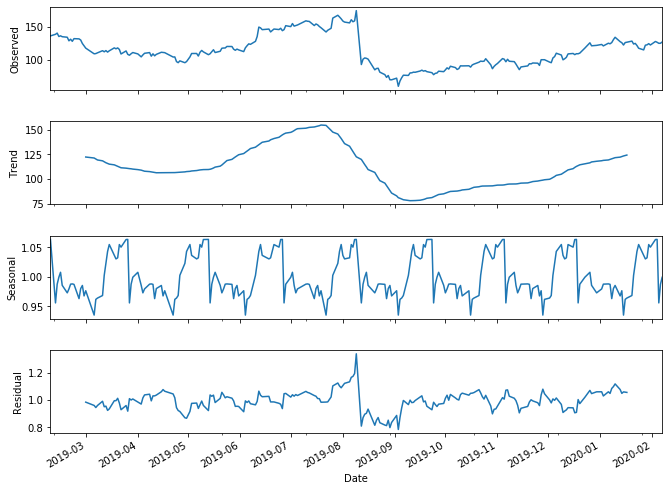

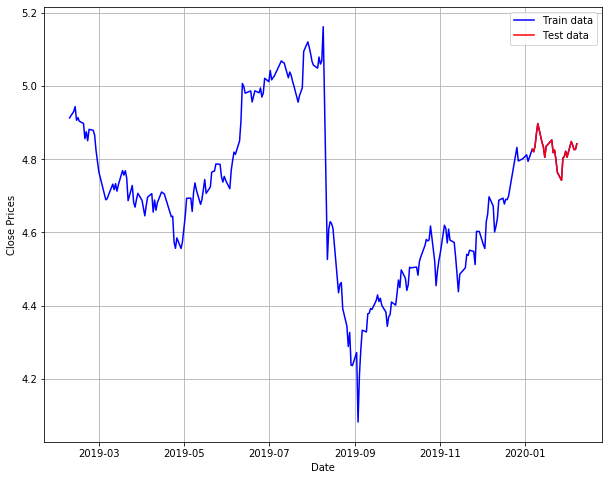

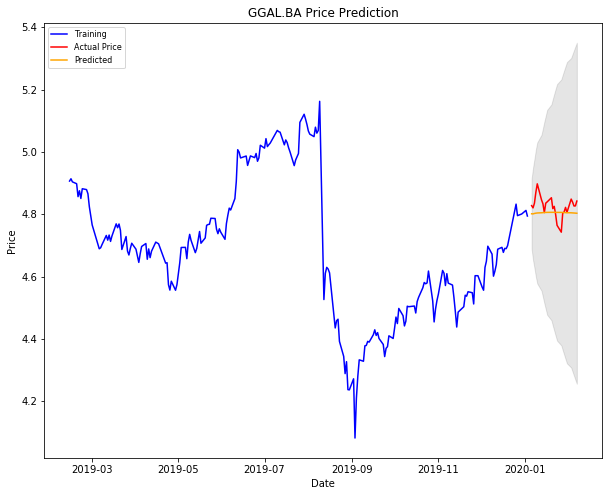

TICKER: BMA.BA
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<Figure size 432x288 with 0 Axes>

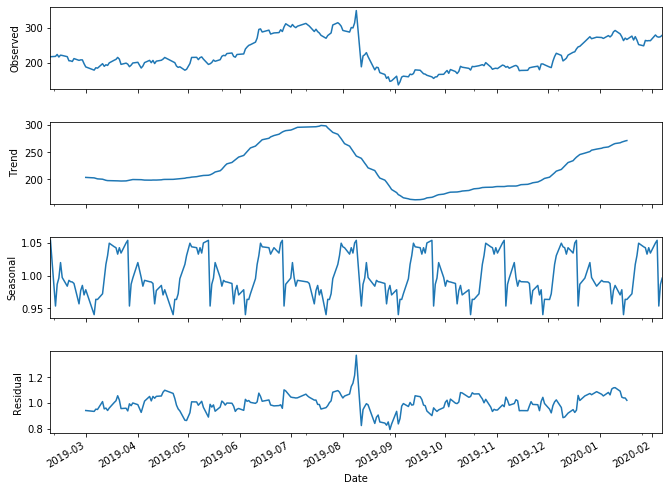

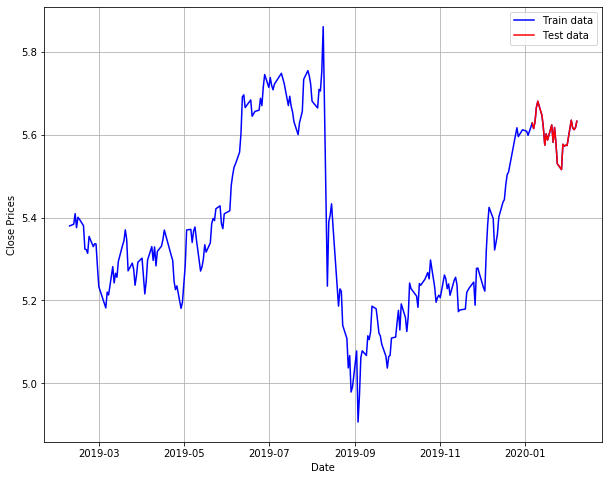

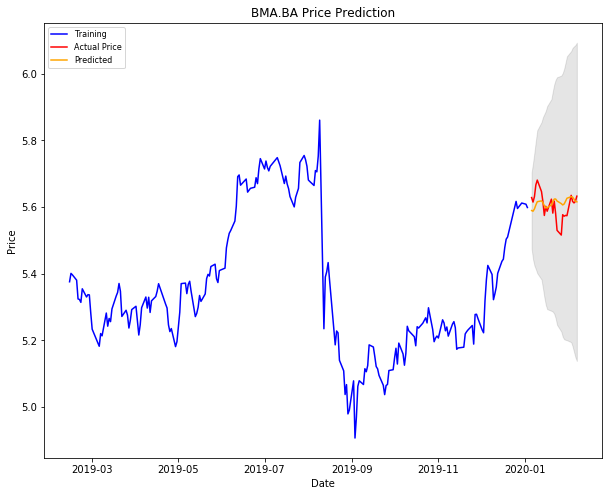

TICKER: SUPV.BA
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<Figure size 432x288 with 0 Axes>

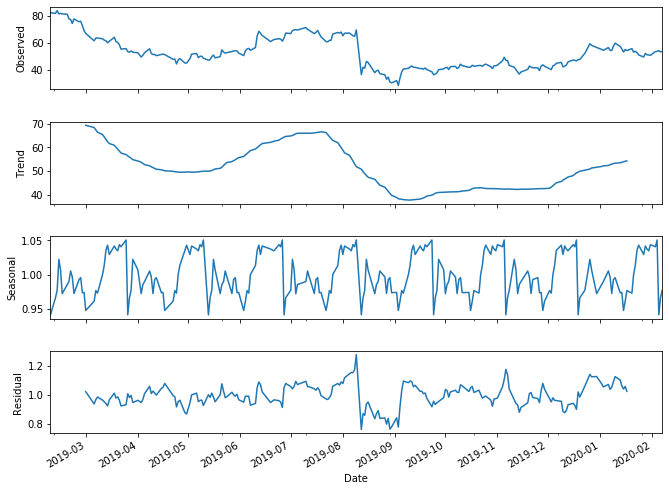

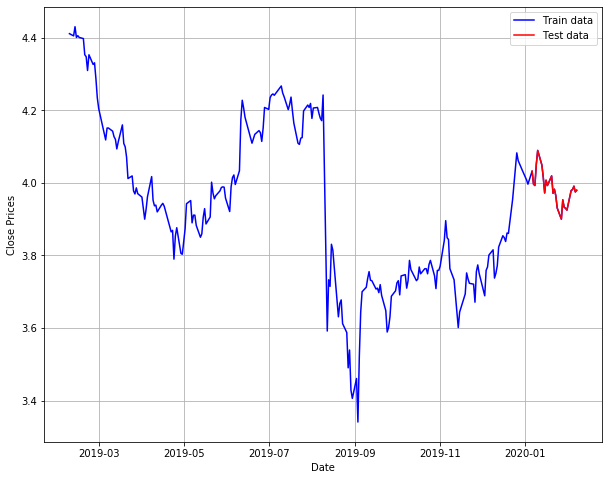

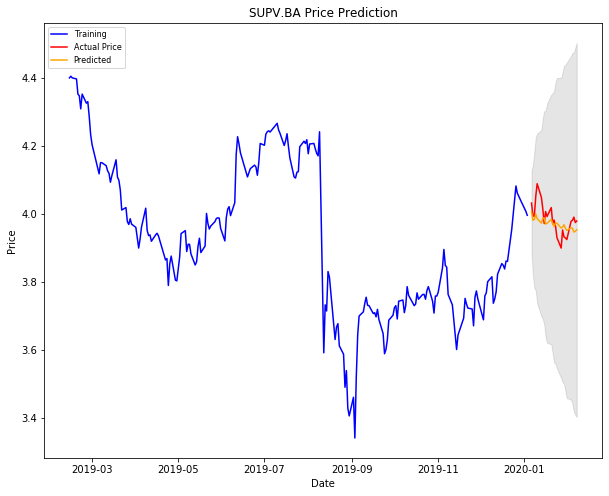

In [20]:
all_portfolio_banking = ['BHIP.BA', 'BMA.BA', 'BPAT.BA', 'BRIO.BA', 'GGAL.BA']

for ticker in portfolio_banking:
  print("TICKER: " + ticker)
  df = yf.download(ticker, period='1y')
  predict_price_by_history(df['Close'], ticker)                  